<a href="https://colab.research.google.com/github/thinhngo-x/polyshell/blob/main/polyshell_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import shapely.geometry as geom


In [ ]:
def polygon_orientation(polygon):
    """
    Determines the orientation of a polygon (clockwise or counter-clockwise)
    using the shoelace formula.

    Args:
        polygon: A list of (x, y) tuples representing the vertices.

    Returns:
        "counter_clockwise" if the orientation is positive,
        "clockwise" if the orientation is negative,
        "collinear" if the area is zero (degenerate polygon).
    """
    n = len(polygon)
    if n < 3:
        return "collinear" # Cannot determine orientation for less than 3 vertices
    area = 0.0
    for i in range(n):
        x1, y1 = polygon[i]
        x2, y2 = polygon[(i + 1) % n]
        area += (x1 * y2 - x2 * y1)
    signed_area = area / 2.0
    if signed_area > 0:
        return "counter_clockwise"
    elif signed_area < 0:
        return "clockwise"
    else:
        return "collinear"

def cross_product(o, a, b):
    """Calculates the 2D cross product of vectors OA and OB."""
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

def identify_concave_vertices(polygon, orientation):
    """
    Identifies concave vertices in a 2D polygon based on cross product,
    considering the polygon's orientation.

    Args:
        polygon: A list of (x, y) tuples representing the vertices.
        orientation: The orientation of the polygon ("counter_clockwise" or "clockwise").

    Returns:
        A list of indices of the concave vertices.
    """
    n = len(polygon)
    if n < 3 or orientation == "collinear":
        return []
    concave_vertices = []
    for i in range(n):
        prev_vertex = polygon[(i - 1) % n]
        current_vertex = polygon[i]
        next_vertex = polygon[(i + 1) % n]
        cp = cross_product(prev_vertex, current_vertex, next_vertex)

        if orientation == "counter_clockwise":
            if cp < 0: # Right turn for CCW is concave
                concave_vertices.append(i)
        elif orientation == "clockwise":
            if cp > 0: # Left turn for CW is concave
                concave_vertices.append(i)
    return concave_vertices

In [ ]:
def distance_point_to_line(point, line_start, line_end):
    """Calculate the distance from a point to a line segment."""
    if np.array_equal(line_start, line_end):
        return np.linalg.norm(point - line_start)

    line_vec = line_end - line_start
    point_vec = point - line_start
    line_len = np.linalg.norm(line_vec)
    line_unit_vec = line_vec / line_len

    projection_length = np.dot(point_vec, line_unit_vec)
    projection_length = np.clip(projection_length, 0, line_len)

    closest_point = line_start + projection_length * line_unit_vec
    return np.linalg.norm(point - closest_point)

def reduce_polygon(vertices, tolerance):
    """Reduce the number of vertices in a polygon while ensuring coverage."""
    if len(vertices) < 3:
        return vertices

    # Start with the first and last vertex
    reduced_vertices = [vertices[0]]

    for i in range(1, len(vertices) - 1):
        # Check distance from the current vertex to the line segment
        dist = distance_point_to_line(vertices[i], vertices[i-1], vertices[i+1])
        if dist > tolerance:
            reduced_vertices.append(vertices[i])

    reduced_vertices.append(vertices[-1])
    return np.array(reduced_vertices)

def estimate_polygon_area(vertices):
    """Calculate the area of a polygon given its vertices."""
    polygon = geom.Polygon(vertices)
    return polygon.area


def triangle_area(p1, p2, p3):
    """Calculate the area of a triangle formed by three points."""
    return 0.5 * np.abs(p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1]))

def adjusted_triangle_area(v, vf, vt, orientation):
    cp = cross_product(vf, v, vt)
    if orientation == "counter_clockwise":
        return triangle_area(vf, v, vt) if cp <= 0 else np.inf
    elif orientation == "clockwise":
        return triangle_area(vf, v, vt) if cp >= 0 else np.inf

def visvalingam_whyatt(vertices, tolerance):
    """Simplify a polygon using the Visvalingam-Whyatt algorithm."""
    if len(vertices) < 3:
        return vertices

    polygon_area = estimate_polygon_area(vertices)
    orientation = polygon_orientation(vertices)

    # Calculate the area of triangles formed by each vertex
    areas = []
    for i in range(1, len(vertices) - 1):
        area = adjusted_triangle_area(
            vertices[i], vertices[i-1], vertices[i+1],
            orientation
        ) / polygon_area
        areas.append((area, i))

    # Create a list of vertices to keep
    keep_vertices = list(range(len(vertices)))

    while areas:
        # Find the index of the vertex with the smallest area
        areas.sort()  # Sort by area
        smallest_area, vertex_to_remove = areas[0]

        # Remove the vertex if its area is below the tolerance
        if smallest_area < tolerance and len(keep_vertices) >= 3:
            removed_idx = keep_vertices.index(vertex_to_remove)
            keep_vertices.remove(vertex_to_remove)
            areas.pop(0)

            # Recalculate area of new triangles
            areas = [
                (adjusted_triangle_area(
                    vertices[keep_vertices[i % len(keep_vertices)]],
                    vertices[keep_vertices[(i-1) % len(keep_vertices)]],
                    vertices[keep_vertices[(i+1) % len(keep_vertices)]],
                    orientation
                ) / polygon_area, keep_vertices[i % len(keep_vertices)])
                for i in range(len(keep_vertices))\
            ]
        else:
            break

    # Return the simplified polygon
    return vertices[keep_vertices]

In [ ]:
"""Generate random concave polygons.

https://stackoverflow.com/a/25276331/30061514
"""

import math, random
from typing import List, Tuple


def generate_polygon(center: Tuple[float, float], avg_radius: float,
                     irregularity: float, spikiness: float,
                     num_vertices: int) -> List[Tuple[float, float]]:
    """
    Start with the center of the polygon at center, then creates the
    polygon by sampling points on a circle around the center.
    Random noise is added by varying the angular spacing between
    sequential points, and by varying the radial distance of each
    point from the centre.

    Args:
        center (Tuple[float, float]):
            a pair representing the center of the circumference used
            to generate the polygon.
        avg_radius (float):
            the average radius (distance of each generated vertex to
            the center of the circumference) used to generate points
            with a normal distribution.
        irregularity (float):
            variance of the spacing of the angles between consecutive
            vertices.
        spikiness (float):
            variance of the distance of each vertex to the center of
            the circumference.
        num_vertices (int):
            the number of vertices of the polygon.
    Returns:
        List[Tuple[float, float]]: list of vertices, in CCW order.
    """
    # Parameter check
    if irregularity < 0 or irregularity > 1:
        raise ValueError("Irregularity must be between 0 and 1.")
    if spikiness < 0 or spikiness > 1:
        raise ValueError("Spikiness must be between 0 and 1.")

    irregularity *= 2 * math.pi / num_vertices
    spikiness *= avg_radius
    angle_steps = random_angle_steps(num_vertices, irregularity)

    # now generate the points
    points = []
    angle = random.uniform(0, 2 * math.pi)
    for i in range(num_vertices):
        radius = clip(random.gauss(avg_radius, spikiness), 0, 2 * avg_radius)
        point = (center[0] + radius * math.cos(angle),
                 center[1] + radius * math.sin(angle))
        points.append(point)
        angle += angle_steps[i]

    return points


def random_angle_steps(steps: int, irregularity: float) -> List[float]:
    """Generates the division of a circumference in random angles.

    Args:
        steps (int):
            the number of angles to generate.
        irregularity (float):
            variance of the spacing of the angles between consecutive vertices.
    Returns:
        List[float]: the list of the random angles.
    """
    # generate n angle steps
    angles = []
    lower = (2 * math.pi / steps) - irregularity
    upper = (2 * math.pi / steps) + irregularity
    cumsum = 0
    for i in range(steps):
        angle = random.uniform(lower, upper)
        angles.append(angle)
        cumsum += angle

    # normalize the steps so that point 0 and point n+1 are the same
    cumsum /= (2 * math.pi)
    for i in range(steps):
        angles[i] /= cumsum
    return angles


def clip(value, lower, upper):
    """
    Given an interval, values outside the interval are clipped to the interval
    edges.
    """
    return min(upper, max(value, lower))

vertices = np.array(generate_polygon(center=(250, 250),
                            avg_radius=100,
                            irregularity=0.2,
                            spikiness=0.25,
                            num_vertices=100))

polygon = geom.Polygon(vertices)
reduced_vertices = polygon.simplify(tolerance=10, preserve_topology=True)

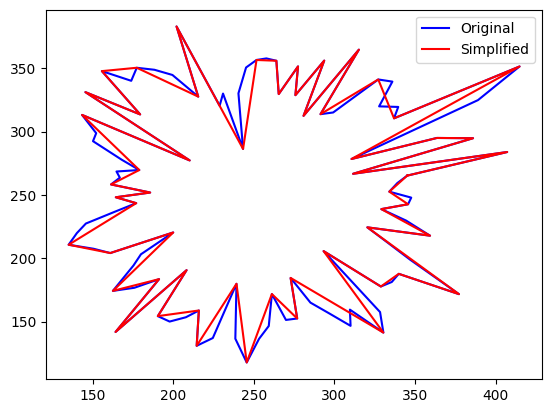

In [ ]:
def plot_shapely_polygon(polygon, reduced_vertices=None):
    fig, ax = plt.subplots()

    # Original polygon
    x, y = polygon.exterior.xy
    ax.plot(x, y, 'b-', label="Original")

    # Simplified polygon
    x, y = reduced_vertices.exterior.xy
    ax.plot(x, y, 'r-', label="Simplified")

    ax.legend()
    plt.show()

plot_shapely_polygon(polygon, reduced_vertices)
# Using normal Douglas-Peucker algorithm
# https://shapely.readthedocs.io/en/stable/reference/shapely.Polygon.html#shapely.Polygon.simplify

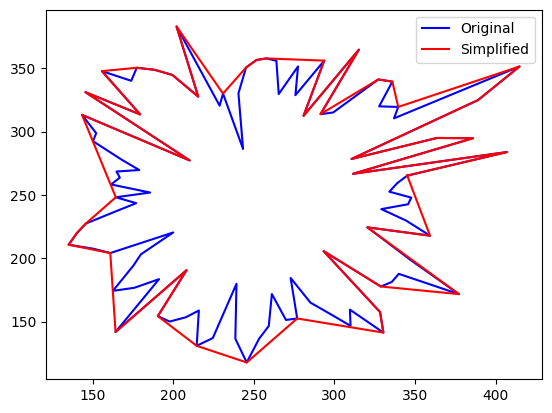

In [ ]:
adjusted_reduced_vertices = visvalingam_whyatt(vertices, 0.01)
adjusted_reduced_polygon = geom.Polygon(adjusted_reduced_vertices)
plot_shapely_polygon(
    polygon,
    reduced_vertices=adjusted_reduced_polygon
)

# Using adjusted visvalingam whyatt algorithm
# https://en.wikipedia.org/wiki/Visvalingam%E2%80%93Whyatt_algorithm